# Google Art & Culture - Case study using CRISPS-DM

#### Autors: Manuel Alejandro Aponte, Cristian Beltran, Maria Paula Peña

In this notebook you will explore data and create classification models

## Objectives
The objective of this notebooks is:

* Visualize the data through graphs.
* test different classification model based in dataset
* Optimize model by means of hyperparameters.

## Prerequisites

* Familiarity with Python, Sklearn & Grid Search. 
* Install python packages.

## Background 
This notebook belongs to Google Art & Culture Case Study using CRIPS-DM, where would be include process such as webscraping, exploratory data analysis, ML classificators and dashboards.

# TODO: 

**EDA**

**NN for classification**

**Stratify cross validation**

**Metric** 

## Libraries 📚

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)
warnings.filterwarnings("ignore")

## Load data

In [3]:
df = pd.read_csv('../data/final/pictures.csv')
df.head(5)

,index,category,filename,Title,Date Created,Dimensions,Artist,mean_grayscale,mean_blue,mean_green,mean_red,std_grayscale,std_blue,std_green,std_red
0,0,WHITE,0.jpg,"Symphony in White, No. 1 The White Girl",1862,overall 213 x 107.9 cm (83 7/8 x 42 1/2 in.) ...,James McNeill Whistler,0.707468,0.592548,0.702255,0.759860,0.113919,0.112658,0.117957,0.108062
1,1,WHITE,1.jpg,The Cradle,1872,w460 x h560 cm,Berthe Morisot,0.591144,0.519539,0.586287,0.626952,0.204013,0.186520,0.203947,0.212146
2,2,WHITE,2.jpg,The Magpie,1868 - 1869,w1300 x h890 mm,Claude Monet,0.687141,0.638097,0.687555,0.704309,0.133684,0.122419,0.133433,0.139909
3,3,WHITE,3.jpg,Summer evening on Skagen Sønderstrand,1893,100 × 150 cm,Peder Severin Krøyer,0.696685,0.713158,0.700890,0.682375,0.119145,0.071436,0.113651,0.153838
4,4,WHITE,4.jpg,"Composition with red, yellow and blue",1927,40 x 52 cm,Piet Mondriaan,0.836621,0.802547,0.829830,0.862469,0.246921,0.279878,0.261812,0.241762


In [4]:
y = df['category']
X = df[['mean_grayscale','mean_blue','mean_green','mean_red','std_grayscale','std_blue','std_green','std_red']] 

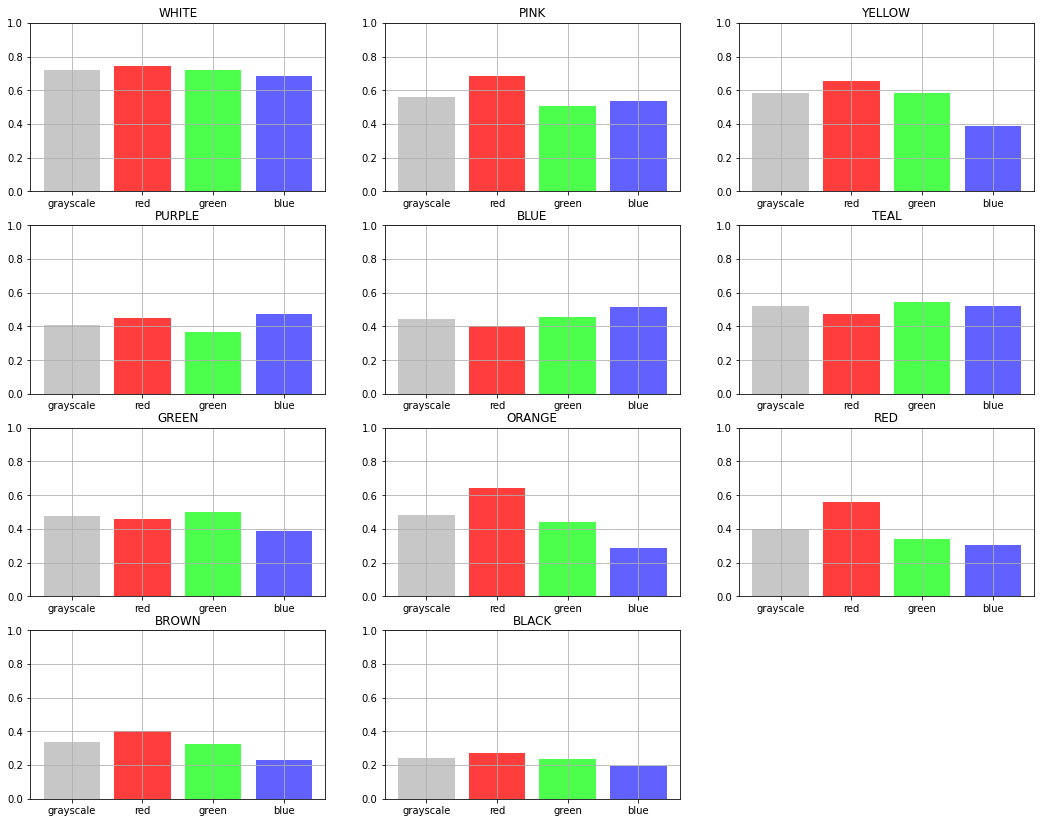

In [75]:
plt.figure(figsize=(18, 18))

for i,category in enumerate(df['category'].unique()):
    category_df = df[df['category']==category]
    color_values = category_df[['mean_grayscale','mean_red', 'mean_green','mean_blue']].mean()
    plt.subplot(5, 3, i+1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.bar(['grayscale','red','green','blue'],color_values ,color =['#C7C7C7','#FF3D3D','#4DFF4D','#6161FF'])
    plt.title(category)





0.6822335313885138

# EDA

Text(0.5, 1.0, 'Sales correlation')

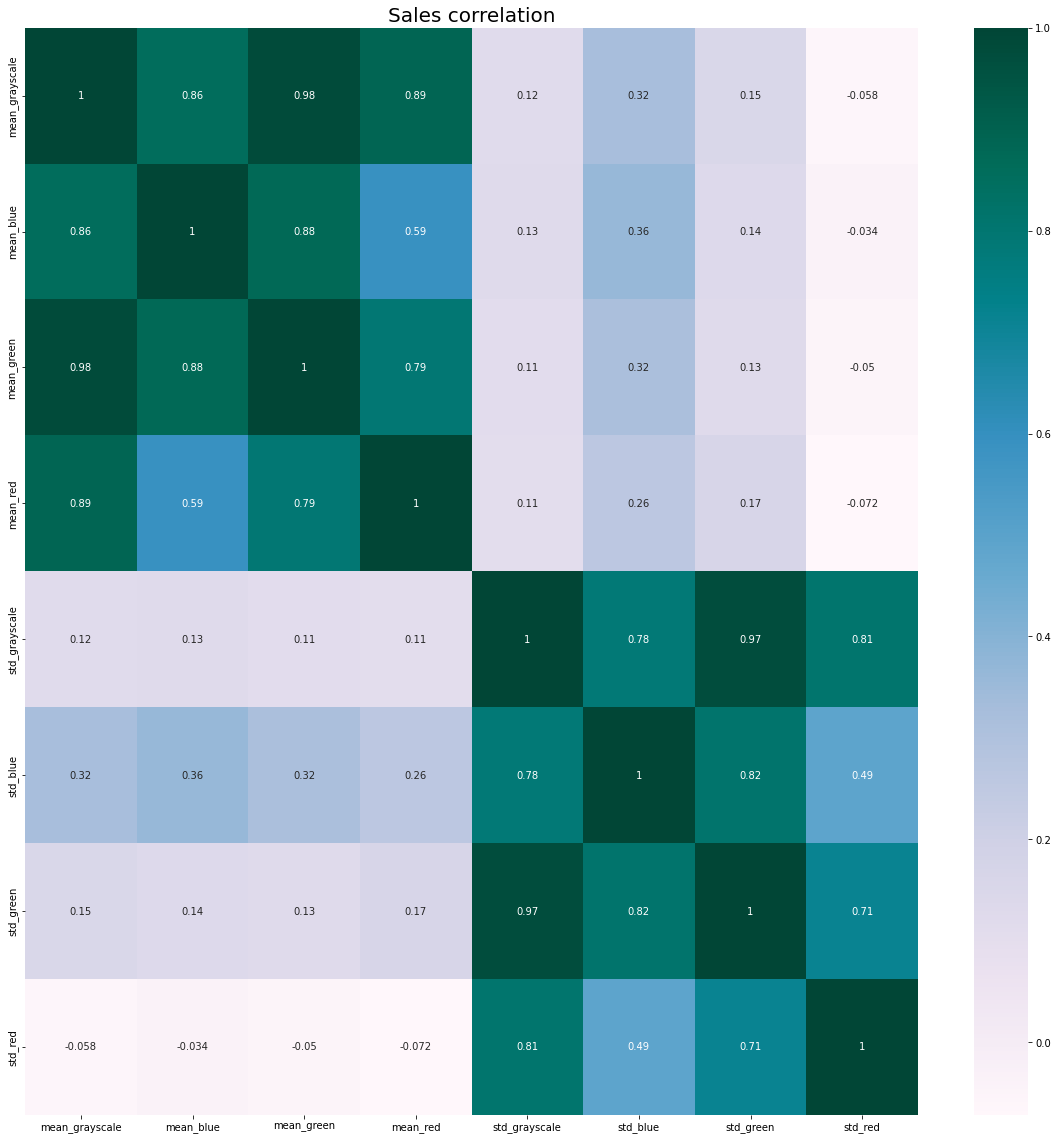

In [17]:
plt.figure(figsize=(20,20))
hm=sns.heatmap(X.corr(),cmap="PuBuGn",annot=True)
hm.set_title('Sales correlation', fontdict={'fontsize':20})

### Considerations

* The differents types of std (grayscale, blue, green and red) are very correlated between them , so std_blue, std_green, std_red will be deleted
* mean_grayscale produces high correlation with mean_blue, mean_green and mean_red, so mean_grayscale will be deleted

In [19]:
X = X[['mean_blue','mean_green','mean_red','std_grayscale']]

# Exploration of data and Models 📊

In [20]:
le = LabelEncoder()
y= le.fit_transform(y)
y


array([9, 9, 9, ..., 0, 0, 0])

## Models 📈

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier


def modelPipeline(X, y):
    
    default_params = {'random_state':42}    
    log_reg = LogisticRegression(**default_params|{'max_iter':10000})
    knn = KNeighborsClassifier()
    svm = SVC(**default_params)
    NN = MLPClassifier(**default_params)
        
    models = [
            ('Logistic Regression', log_reg, {"penalty":['l2','none'], 'C':np.logspace(-4, 2, num=2)}), 
            ('K-Nearest Neighbors', knn, {'n_neighbors':[3,9,12], 'metric': ['l1','l2']}), 
            ('SVM', svm, {'C': np.logspace(-1, 5, num=3),'gamma': np.logspace(-4, 0, num=2), 'kernel':['rbf','linear']}),
            ('Neural Network',NN, {'hidden_layer_sizes':[(10,10,10),(50,40,20),(150,100,50)]} )
            ]
    

    
    results = pd.DataFrame(columns=['model','params','mean_test_score'])
    for name,model,params in models:
        print('Training:',name)
        classifier = GridSearchCV(model,params,cv=3,return_train_score=False)
        classifier.fit(X,y)
        full_report = pd.DataFrame(classifier.cv_results_)
        full_report['model']= name
        report = full_report[['model','params','mean_test_score','mean_fit_time']]
        results = pd.concat([results, report])
        
    results = results.reset_index(drop=True)
    return results

models_df = modelPipeline(X,y)
    

Training: Logistic Regression
Training: K-Nearest Neighbors
Training: SVM
Training: Neural Network


# Model Selection

### Search the models with best test scores

In [67]:
models_df2 = models_df.reset_index(drop=True)

In [68]:
models_df2

,model,params,mean_test_score,mean_fit_time
0,Logistic Regression,"{'C': 0.0001, 'penalty': 'l2'}",0.228930,0.052665
1,Logistic Regression,"{'C': 0.0001, 'penalty': 'none'}",0.766404,0.844786
2,Logistic Regression,"{'C': 100.0, 'penalty': 'l2'}",0.763488,0.652716
3,Logistic Regression,"{'C': 100.0, 'penalty': 'none'}",0.766404,0.839746
4,K-Nearest Neighbors,"{'metric': 'l1', 'n_neighbors': 3}",0.703801,0.005999
5,K-Nearest Neighbors,"{'metric': 'l1', 'n_neighbors': 9}",0.729562,0.006334
6,K-Nearest Neighbors,"{'metric': 'l1', 'n_neighbors': 12}",0.731311,0.006335
7,K-Nearest Neighbors,"{'metric': 'l2', 'n_neighbors': 3}",0.700301,0.006334
8,K-Nearest Neighbors,"{'metric': 'l2', 'n_neighbors': 9}",0.728492,0.005999
9,K-Nearest Neighbors,"{'metric': 'l2', 'n_neighbors': 12}",0.732381,0.005999


In [70]:
models_df2.sort_values('mean_test_score',ascending=False)

,model,params,mean_test_score,mean_fit_time
24,Neural Network,"{'hidden_layer_sizes': (150, 100, 50)}",0.777292,10.093613
23,Neural Network,"{'hidden_layer_sizes': (50, 40, 20)}",0.775250,6.706197
16,SVM,"{'C': 100.0, 'gamma': 1.0, 'kernel': 'rbf'}",0.774764,0.387000
20,SVM,"{'C': 100000.0, 'gamma': 1.0, 'kernel': 'rbf'}",0.774375,13.323704
21,SVM,"{'C': 100000.0, 'gamma': 1.0, 'kernel': 'linear'}",0.773889,14.477802
19,SVM,"{'C': 100000.0, 'gamma': 0.0001, 'kernel': 'li...",0.773889,14.491274
17,SVM,"{'C': 100.0, 'gamma': 1.0, 'kernel': 'linear'}",0.772140,0.339333
15,SVM,"{'C': 100.0, 'gamma': 0.0001, 'kernel': 'linear'}",0.772140,0.339000
3,Logistic Regression,"{'C': 100.0, 'penalty': 'none'}",0.766404,0.839746
1,Logistic Regression,"{'C': 0.0001, 'penalty': 'none'}",0.766404,0.844786


In [35]:
#models_df.loc[models_df.reset_index().groupby('model', as_index=False).agg('max').idxmax()]
models_df.loc[models_df.groupby('model')['mean_test_score'].idxmax()]

,model,params,mean_test_score,mean_fit_time
5,Logistic Regression,"{'C': 100.0, 'penalty': 'none'}",0.766404,0.834785
5,K-Nearest Neighbors,"{'metric': 'l2', 'n_neighbors': 12}",0.732381,0.006334
5,SVM,"{'C': 0.1, 'gamma': 10.0, 'kernel': 'linear'}",0.540196,0.708302
1,Logistic Regression,"{'C': 0.0001, 'penalty': 'none'}",0.766404,0.849845
1,K-Nearest Neighbors,"{'metric': 'l1', 'n_neighbors': 9}",0.729562,0.005998
1,SVM,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}",0.540196,0.718842
1,Neural Network,"{'hidden_layer_sizes': (50, 40, 20)}",0.775250,6.809790
2,Logistic Regression,"{'C': 0.1, 'penalty': 'l2'}",0.557305,0.092117
2,K-Nearest Neighbors,"{'metric': 'l1', 'n_neighbors': 12}",0.731311,0.006334
2,SVM,"{'C': 0.1, 'gamma': 0.03162277660168379, 'kern...",0.316322,1.667059


#### SVC (Super Vector Machine Classifier) 

In [15]:
X_train,X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y,random_state=32)
# And here we train our model. IMPORTANT: we use kernel='linear'.
svc_model = SVC(kernel='linear', random_state=32)
svc_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=32)

In [21]:
y_pred = svc_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[313,   4,  39,   6,   0,   0,   0,   0,   2,   0,   1],
       [ 16, 263,   0,   1,   0,   0,   0,   4,  59,  22,   0],
       [ 69,   0, 252,   9,   8,   0,   0,   4,   1,   0,  22],
       [ 16,   3,  17, 249,   1,   0,   0,   0,  44,  15,  20],
       [  1,   0,  17,   2, 136,   0,   0,  40,   0,   0,  47],
       [  0,   1,   0,   0,   0,   0,   0,  16,   0,   7,   2],
       [  1,  23,   0,   0,   0,   0,   0,  12,   0,   0,   0],
       [ 19,   8,  36,   2,  13,   0,   0, 221,   3,  11,   4],
       [  6,  56,   3,  30,   0,   0,   0,   1, 244,  23,   1],
       [  2,   4,   1,   3,   0,   0,   0,   3,   1, 307,  16],
       [  1,   1,  12,  26,  10,   0,   0,   1,   0,  31, 222]],
      dtype=int64)

In [20]:
# print prediction results
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       BLACK       0.70      0.86      0.77       365
        BLUE       0.72      0.72      0.72       365
       BROWN       0.67      0.69      0.68       365
       GREEN       0.76      0.68      0.72       365
      ORANGE       0.81      0.56      0.66       243
        PINK       0.00      0.00      0.00        26
      PURPLE       0.00      0.00      0.00        36
         RED       0.73      0.70      0.71       317
        TEAL       0.69      0.67      0.68       364
       WHITE       0.74      0.91      0.82       337
      YELLOW       0.66      0.73      0.69       304

    accuracy                           0.71      3087
   macro avg       0.59      0.59      0.59      3087
weighted avg       0.70      0.71      0.71      3087



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.602 total time=   2.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.581 total time=   2.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.585 total time=   2.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.601 total time=   2.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.597 total time=   2.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.399 total time=   3.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.384 total time=   2.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.390 total time=   3.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.403 total time=   3.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.380 total time=   3.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.140 total time=   3.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [27]:
grid.best_estimator_

SVC(C=1000, gamma=1)

In [25]:
grid_predictions = grid.predict(X_test)
 
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

       BLACK       0.87      0.85      0.86       365
        BLUE       0.81      0.83      0.82       365
       BROWN       0.83      0.82      0.83       365
       GREEN       0.82      0.82      0.82       365
      ORANGE       0.84      0.84      0.84       243
        PINK       0.67      0.62      0.64        26
      PURPLE       0.78      0.69      0.74        36
         RED       0.84      0.84      0.84       317
        TEAL       0.77      0.79      0.78       364
       WHITE       0.91      0.92      0.91       337
      YELLOW       0.79      0.76      0.78       304

    accuracy                           0.83      3087
   macro avg       0.81      0.80      0.80      3087
weighted avg       0.83      0.83      0.83      3087



In [30]:
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
#https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
# https://en.wikipedia.org/wiki/Radial_basis_function_kernel